<a href="https://colab.research.google.com/github/imji0319/PDSH/blob/master/OnlineRetail_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RFM 기반 고객 세그멘테이션

In [35]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
cd /content/gdrive/My Drive/data

/content/gdrive/My Drive/data


In [5]:
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
%matplotlib inline 


retail_df = pd.read_excel(io='Online Retail.xlsx')
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [7]:
retail_df.shape

(541909, 8)

In [8]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


- NULL 데이터 제거 : customer segmentation을 위해 customerID가 없는 경우 삭제 
- 오류 데이터 제거
    1. Quantity < 0 
    2. UnitPrice < 0 

In [9]:
retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df = retail_df[retail_df['UnitPrice'] > 0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]

print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

- 주요 주문 고객이 영국으로 그 외 다른 국가의 데이터는 모두 삭제

In [10]:
retail_df = retail_df[retail_df['Country'] == 'United Kingdom']
print(retail_df.shape)

(354321, 8)


필요한 데이터 가공
- 주문 금액 데이터 (sale_amount) = 주문수량 (Quantity)  * 제품 단가(UnitPrice)
- CustomerID 형태 int 로 변환 

In [0]:
retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

In [13]:
# TOP-5 주문 건수와 주문 금액을 가진 고객 데이터를 추출
print( retail_df['CustomerID'].value_counts().head(5) )
print( retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


In [14]:
retail_df.groupby(['InvoiceNo', 'StockCode'])['InvoiceNo'].count().mean()

1.028702077315023

DateFrame 의 groupby() 의 multiple 연산을 위해 agg() 이용
- Recency : InvoiceDate의 max() 
- Frequency :  InvoiceNo의 count()
- Monetary : sale_amount의 sum()

In [15]:
aggregations = {
    
    'InvoiceDate' : 'max',
    'InvoiceNo':'count',
    'sale_amount':'sum'
    
}

cust_df = retail_df.groupby('CustomerID').agg(aggregations)
cust_df = cust_df.rename(columns = {'InvoiceDate' : 'Recency',
                                                            'InvoiceNo' : 'Frequency',
                                                            'sale_amount' : 'Monetary'}
                                        )

cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


In [19]:
import datetime as dt

cust_df['Recency'] = dt.datetime(2011,12,10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days+1)

print('cust_df 로우와 칼럼 건수는 ', cust_df.shape)
cust_df.head(3)

cust_df 로우와 칼럼 건수는  (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


온라인 판매 데이터 세틑는 소매업체의 대규모 주문을 포함
- 주문 횟수와 주문 금액에서 개인 고객 주문과 매우 큰 차이를 보임 
- 왜곡된 데이터 분포도를 가지게 되어 군집화가 한쪽 군집에만 집중되는 현상 발생

(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <a list of 10 Patch objects>)

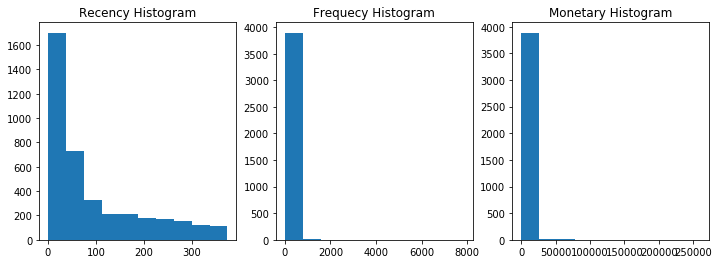

In [20]:
fig, (ax1, ax2, ax3) =plt.subplots(figsize=(12,4), nrows =1 , ncols = 3)

ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])


ax2.set_title('Frequecy Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

In [23]:
# 데이터 값의 백분위 

cust_df[['Recency' ,'Frequency','Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


왜곡이 심한 데이터 그대로 Kmeans 군집화를 할 경우 변별력이 떨어짐 -> StandardScaler

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


X_features = cust_df[['Recency', 'Frequency', 'Monetary' ]].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters = 3, random_state = 0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels 

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

실루엣 스코어는 : 0.592


In [37]:
# 로그 변환 

cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])


X_features = cust_df[['Recency_log', 'Frequency_log', 'Monetary_log' ]].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters = 3, random_state = 0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels 


print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))


실루엣 스코어는 : 0.305
